<a href="https://colab.research.google.com/github/dimastar2310/work/blob/main/Last2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 8.2 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp38-cp38-linux_x86_64.whl size=44089 sha256=b76bcb1807681901679d44d4e49e114c6bb2631669bb4367136612cd15e478c8
  Stored in directory: /root/.cache/pip/wheels/52/dd/2b/10ff8b0ac81b93946bb5fb9e6749bae2dac246506c8774e6cf
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Cloning into 'detectron2'...
remote: Enumerating objects: 14718, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects:

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.2 MB/s 
     |████████████████████████████████| 79 kB 6.5 MB/s 
     |████████████████████████████████| 154 kB 68.1 MB/s 
     |████████████████████████████████| 1.5 MB 52.8 MB/s 
     |████████████████████████████████| 549 kB 56.1 MB/s 
     |████████████████████████████████| 117 kB 44.9 MB/s 
     |████████████████████████████████| 96 kB 5.3 MB/s 
     |████████████████████████████████| 182 kB 52.9 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61431 sha256=a998c88ff26ead06481c662a5f9ffe209f9f2814d07c198f2135fd38540098c3
  Stored in directory: /root/.cache/pip/wheels/b8/79/07/c0e9367f5b5ea325e246bd73651e8af175fabbef943043b1cc
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=9f1d530abf5dd2447e9a5aed6097c7e04d0af0a94b6b1b944c53868

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.13 ; cuda:  cu116
detectron2: 0.6


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Run a pre-trained detectron2 mode

We first download an image from the COCO dataset:

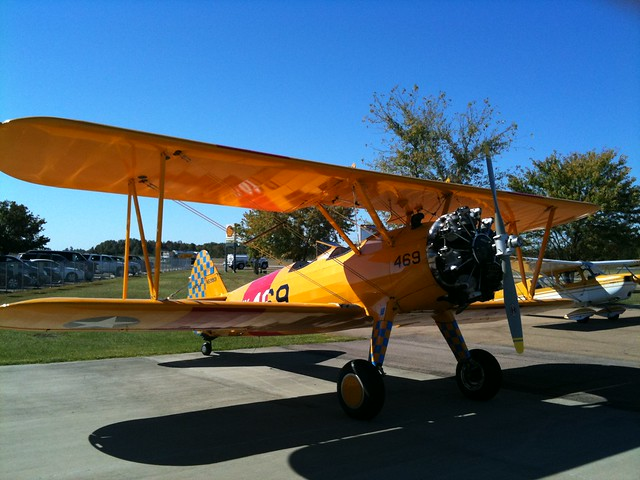

480
480
480
b type? <class 'tuple'>
new image type? <class 'numpy.ndarray'>
width:   640
height:  480
channel: 3


In [4]:
!wget https://farm5.staticflickr.com/4147/5087832865_a8a388de44_z.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")
cv2_imshow(im)
#image size
h,w,c=im.shape




b,g,r = cv2.split(im)

print(len(b))
print(len(g))
print(len(r))

print("b type?",type(b.shape))


newImage = im.copy() #it should do deep copy

print("new image type?",type(newImage))
print('width:  ', w)
print('height: ', h)
print('channel:', c)

[12/21 08:29:49 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:01, 93.7MB/s]                          
/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


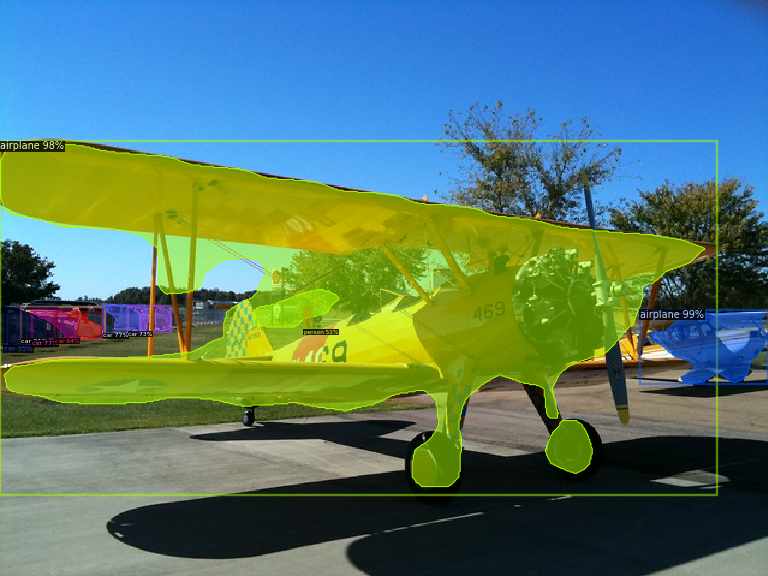

In [5]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.DEVICE = "cpu"
predictor = DefaultPredictor(cfg) #first predictor
outputs = predictor(im) #lpredictor making predictions
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

#tmuna mispar ehad mishtane out

[12/21 08:30:02 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl ...


model_final_cafdb1.pkl: 261MB [00:02, 96.4MB/s]                          


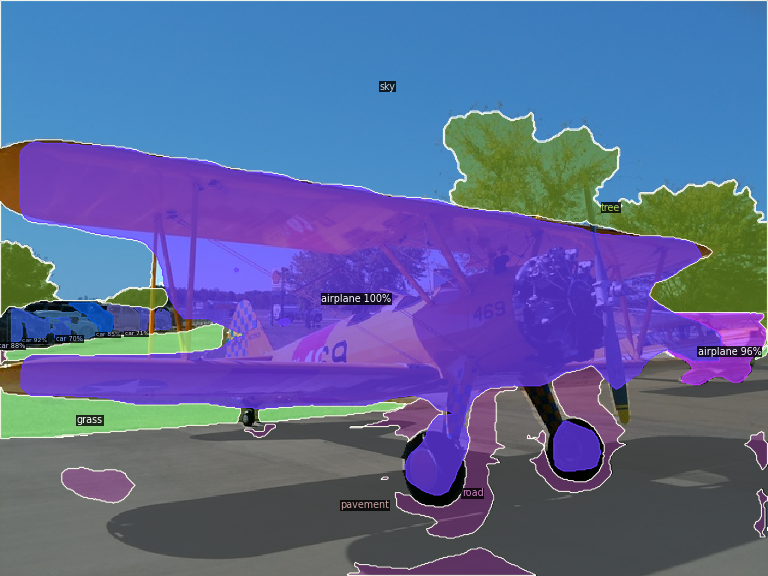

In [6]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
cfg.MODEL.DEVICE = "cpu"
predictor2 = DefaultPredictor(cfg) #this is second predictor

bohen_tmuna = predictor2(im)

panoptic_seg, segments_info = bohen_tmuna["panoptic_seg"]
m_d_c = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
v = Visualizer(im[:, :, ::-1], m_d_c, scale=1.2)
out2 = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out2.get_image()[:, :, ::-1])



#


In [7]:
type(out.get_image())

numpy.ndarray

In [8]:
segments_info

[{'id': 1,
  'isthing': True,
  'score': 0.9962971806526184,
  'category_id': 4,
  'instance_id': 0,
  'area': 85356.0},
 {'id': 2,
  'isthing': True,
  'score': 0.9628826975822449,
  'category_id': 4,
  'instance_id': 1,
  'area': 2585.0},
 {'id': 3,
  'isthing': True,
  'score': 0.9213991761207581,
  'category_id': 2,
  'instance_id': 2,
  'area': 511.0},
 {'id': 4,
  'isthing': True,
  'score': 0.8823044896125793,
  'category_id': 2,
  'instance_id': 3,
  'area': 918.0},
 {'id': 5,
  'isthing': True,
  'score': 0.8525194525718689,
  'category_id': 2,
  'instance_id': 4,
  'area': 482.0},
 {'id': 6,
  'isthing': True,
  'score': 0.7076273560523987,
  'category_id': 2,
  'instance_id': 5,
  'area': 352.0},
 {'id': 7,
  'isthing': True,
  'score': 0.7040168046951294,
  'category_id': 2,
  'instance_id': 6,
  'area': 500.0},
 {'id': 8, 'isthing': False, 'category_id': 21, 'area': 12030.0},
 {'id': 9, 'isthing': False, 'category_id': 37, 'area': 22254.0},
 {'id': 10, 'isthing': False, 'c

In [9]:
type(out)

detectron2.utils.visualizer.VisImage

In [10]:
get_area = 0
for item in segments_info:
           if item.get('isthing')==False and item.get('category_id')== 40: #anahnu bodkim she ze le mashu pashut
                    get_area = item.get('area')
                    print(m_d_c.stuff_classes[40]) #entering methadata catalog 
                    print(get_area)

sky
93353.0


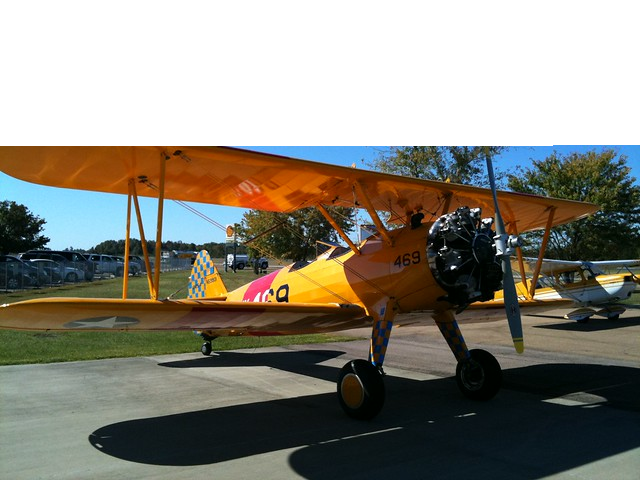

new_i =  145 new_j =  639


In [11]:
c = 0

new_i = 0
new_j = 0
flag = False
for i in range(h):
 for j in range(w):
    if(c<get_area):
      #print(i,j)
      newImage[i][j][0] = 255
      newImage[i][j][1] = 255
      newImage[i][j][2] = 255

      c+=1
    else:
          new_i = i
          new_j = j
          flag = True
 if flag==True: #getting out from 2 loops
   break

      
cv2_imshow(newImage) 
print("new_i = ",new_i,"new_j = ",new_j)
#ze bdika

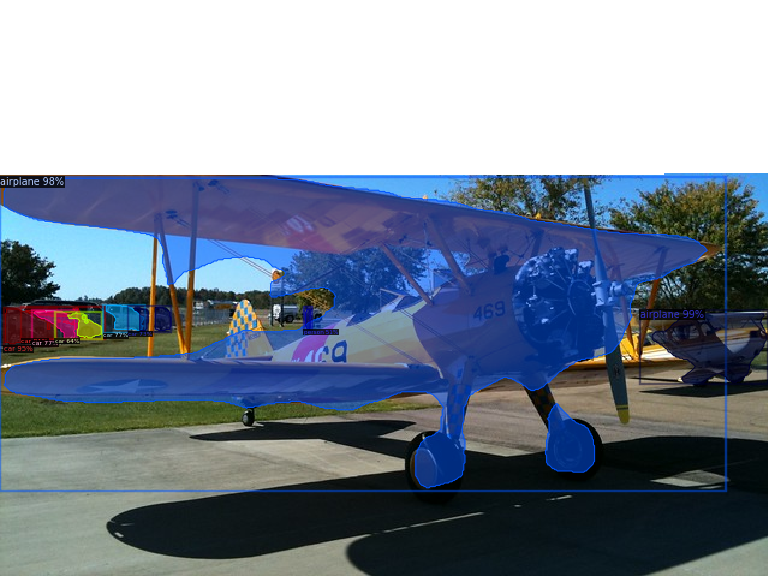

In [12]:
#we have predictor already
outputs = predictor(newImage) #using first predictor
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(newImage[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out3 = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out3.get_image()[:, :, ::-1])


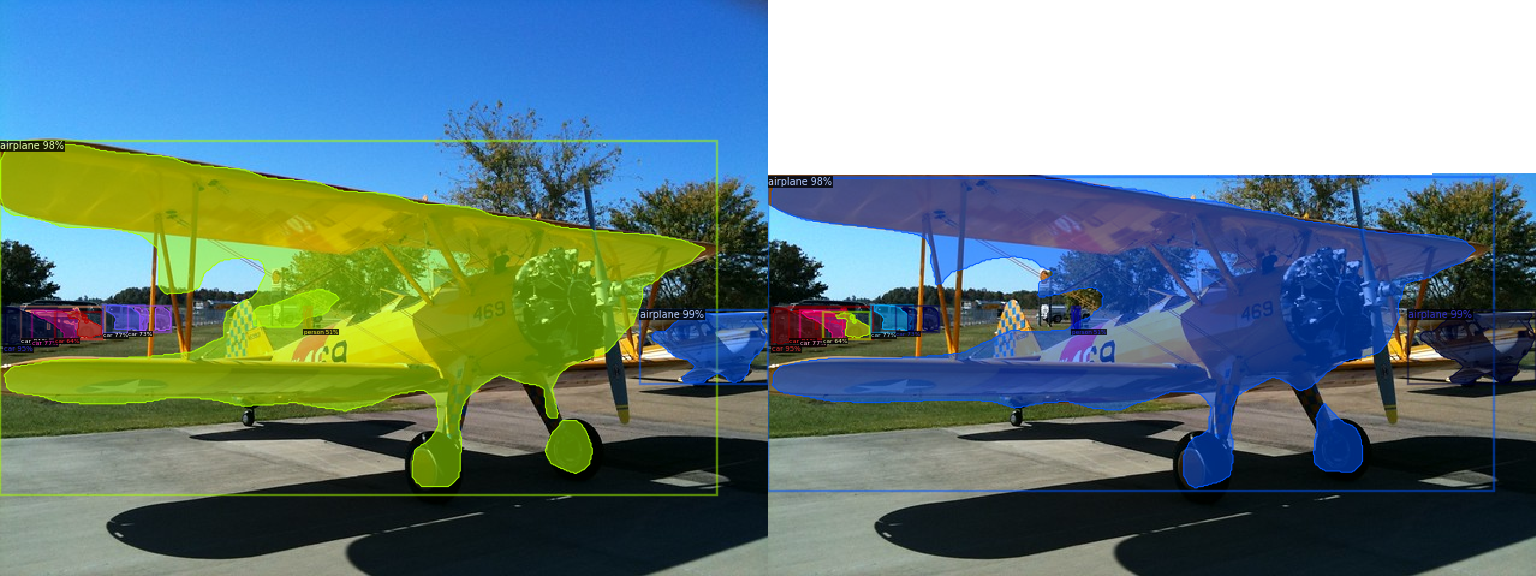

True

In [13]:

a = out.get_image()[:, :, ::-1]
b = out3.get_image()[:, :, ::-1]

vis = np.concatenate((a, b), axis=1)

cv2_imshow(vis)


cv2.imwrite('out.png', vis)

In [14]:
type(out.get_image())

numpy.ndarray

In [15]:
out2